# Creating Price Impact Curves

Here we create price impact curves and store them in our custom `ExternalMarket` object. At a high level, the external market is a K-Nearest-Neighbors interpolation on quotes from the 1inch API. 

Every hour, we query and store quotes from swapping all permutations of tokens over various randomly distributed trade sizes. We do this using `np.geomspace` for a hard-coded min and max trade size for each token (stored in `config`, and somewhat arbitrary, but reasonable). We randomize the geomspace by scaling each point by a noise component. Let's call each set of API calls a <b>round</b>.

In this script, we pull these quotes from our Postgres database, group them by pair, and then perform a simple KNN regression to create our external market. This external market can then "predict" the price impact of trading a particular pair. These predictions are very good for most trade sizes, but become pretty noisy at the extremes (e.g. swapping 10M USDP in one go). We are working on it.

### KNN Regression Motivation

We could do simpler things like a linear or polynomial regression on our data. This works when the market is liquid enough to handle a given trade (i.e., price impact is roughly linear), but performs really poorly for large trade sizes as price impact quickly (and non-linearly) balloons to 100%. 

To address this problem, we instead interpolate the price impact based on the k nearest trade sizes to the trade size we are trying to test. We specify `k` as `n * k_scale`. Here `n` is the number of rounds contained in the dataset, and `k_scale` is a float, like 3/2. Since in expectation each round of API calls will always hit the same points from the `np.geomspace`, this `k` ensures that we look at neighbors outside the expected points along the `np.geomspace` line.

Really, a KNN regression just allows us to fit the data more precisely than a linear regression by considering clusters of trade sizes. Otherwise, our regression would over-index on the residuals of the really large trades (e.g. swapping 100M USDP).

In [30]:
from src.db.datahandler import DataHandler
from src.plotting import plot_price_1inch, plot_regression, plot_predictions
from src.configs.config import ALL, SYMBOL_TO_ADDRESS, ADDRESS_TO_SYMBOL
from src.modules import ExternalMarket

from datetime import datetime
import logging

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
start = int(datetime(2023, 11, 18).timestamp())
with DataHandler() as datahandler:
    quotes = datahandler.get_quotes(start=start, process=True)
print(f"We have {quotes.shape[0]} quotes since {datetime.fromtimestamp(start)}")
quotes.head()

We have 226080 quotes since 2023-11-18 00:00:00


in_amount  \
src                                        dst                                                        
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88    808.302412   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88   2220.498046   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88   4953.924272   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88   8069.759476   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  11837.906544   

                                                                                       out_amount  \
src                                        dst                                                      
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88    0.022006   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88    0.060663   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88    0.135338   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88    0.220799   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88    0.323889   

                                                                                          price  \
src                                        dst                                                    
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88  0.000027   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  0.000027   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  0.000027   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  0.000027   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  0.000027   

                                                                                        timestamp  \
src                                        dst                                                      
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88  1700266538   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  1700266539   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  1700266541   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  1700266543   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88  1700266544   

                                                                                       src_decimals  \
src                                        dst                                                        
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88            18   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88            18   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88            18   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88            18   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88            18   

                                                                                       dst_decimals  \
src                                        dst                                                        
0x0000000000085d4780b73119b644ae5ecd22b376 0x18084fba666a33d37592fa2633fd49a74dd93a88            18   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88            18   
                                           0x18084fba666a33d37592fa2633fd49a74dd93a88            18   
                     

## Fitting Price Impact Curves to Data

Using an illiquid pair as an example. Here we show the expected price impact of swapping WBTC into TUSD using the 1inch router.

Using 196 neighbors


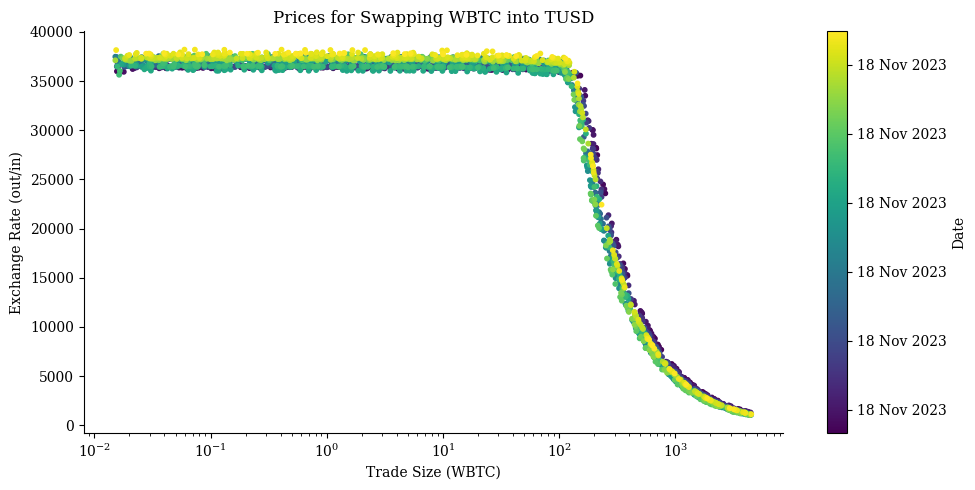

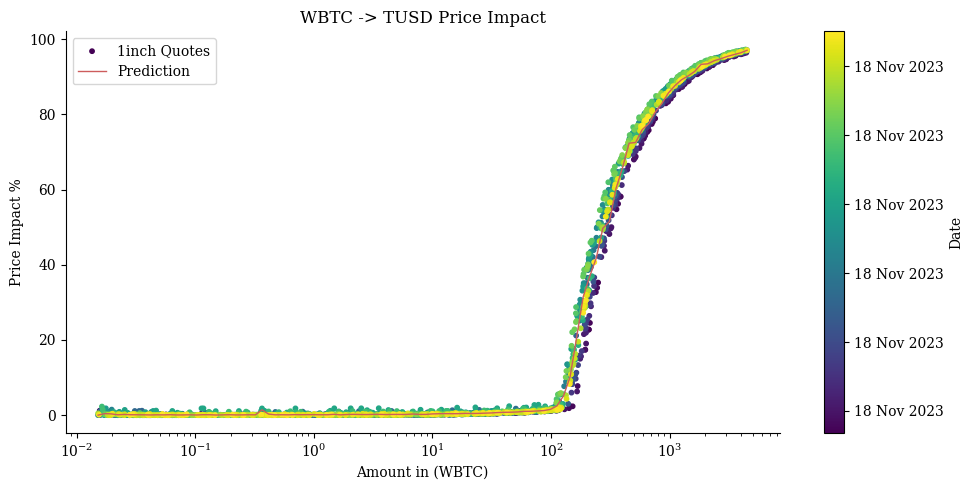

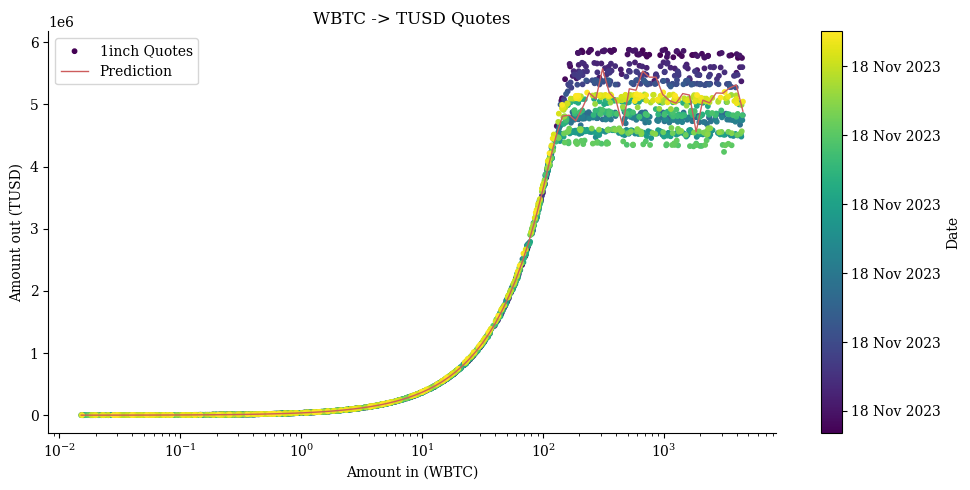

In [4]:
pair = (SYMBOL_TO_ADDRESS["WBTC"], SYMBOL_TO_ADDRESS["TUSD"])
in_token, out_token = pair
in_token_sym = ADDRESS_TO_SYMBOL[in_token]
out_token_sym = ADDRESS_TO_SYMBOL[out_token]

quotes_ = quotes.loc[in_token, out_token]
sample_price = quotes_["reference_price"].mean()

# Trying a KNN regression
market = ExternalMarket(in_token, out_token)
market.fit(quotes_)
market.update_price(sample_price)  # for predictions
print(f"Using {market.k} neighbors")

_ = plot_price_1inch(quotes_, in_token_sym, out_token_sym)
_ = plot_regression(quotes_, in_token_sym, out_token_sym, market, scale="log")
_ = plot_predictions(quotes_, in_token_sym, out_token_sym, market, scale="log")

## Fitting all Markets

Here we show the logic for fitting the price impact curves for all the markets. This generates the same plots as above for each market in the `figs` directory.

In [31]:
PATH = "../figs/price_impacts"  # change this
fn_regr = f"{PATH}/regressions/" + "{}_{}.png"
fn_pred = f"{PATH}/predictions/" + "{}_{}.png"

# This takes a while to plot
pairs = quotes.index.unique()
n = len(pairs)
for i, (in_token, out_token) in enumerate(pairs):
    in_token_sym = ADDRESS_TO_SYMBOL[in_token]
    out_token_sym = ADDRESS_TO_SYMBOL[out_token]

    logging.info(f"Fitting {in_token_sym} -> {out_token_sym}. ({i+1}/{n})")

    quotes_ = quotes.loc[in_token, out_token]
    sample_price = quotes_["reference_price"].mean()

    market = ExternalMarket(in_token, out_token)
    market.fit(quotes_)
    market.update_price(sample_price)  # for predictions

    _ = plot_regression(
        quotes_,
        in_token_sym,
        out_token_sym,
        market,
        scale="log",
        fn=fn_regr.format(in_token_sym, out_token_sym),
    )
    _ = plot_predictions(
        quotes_,
        in_token_sym,
        out_token_sym,
        market,
        scale="log",
        fn=fn_pred.format(in_token_sym, out_token_sym),
    )